In [1]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io, color

rgb = io.imread('Lenna.png')

In [4]:
# reference
# Digital Image Processing(4th edition) P558-559
# https://github.com/wchstrife/DigitalImageProcessing/tree/master/SLIC-Superpixels
# https://www.kawabangga.com/posts/1923

class Cluster(object):
    cluster_index = 1
 
    def __init__(self, x, y, l=0, a=0, b=0):
        self.update(x, y, l, a, b)
        self.pixels = []
        self.no = self.cluster_index
        self.cluster_index += 1
 
    def update(self, x, y, l, a, b):
        self.x = x
        self.y = y
        self.l = l
        self.a = a
        self.b = b
 
    def __str__(self):
        return "{},{}:{} {} {} ".format(self.x, self.y, self.l, self.a, self.b)
 
    def __repr__(self):
        return self.__str__()

class SLIC_supp(object):
    def open_img(self,rgb):
        lab = color.rgb2lab(rgb)
        return lab
    
    def show_cluster(self,x,y):
        return Cluster(x,y,self.data[x][y][0],self.data[x][y][1],self.data[x][y][2])
        
    
    def __init__(self,K,M,rgb):
        self.K = K
        self.M = M
        self.data = self.open_img(rgb)
        self.img_x = self.data.shape[0]
        self.img_y = self.data.shape[1]
        self.N = self.img_x * self.img_y
        self.S = int((self.N / self.K) ** 0.5)
        
        self.clusters = []
        self.dis = np.full((self.img_x, self.img_y), np.inf)
        self.label = {}
        
    def init_clusters(self):
        s = int(self.S/2) - 1
        for i in range(s,self.img_x,self.S):
            for j in range(s,self.img_y,self.S):
                self.clusters.append(self.show_cluster(i,j))
    
    def get_gradient(self,x,y):
        if x + 1 >= self.img_x:
            x = self.img_x - 2
        if y + 1 >= self.img_y:
            y = self.img_y - 2
        gradient = self.data[x + 1][y + 1][0] - self.data[x][y][0] + self.data[x + 1][y + 1][1] - self.data[x][y][1] +self.data[x + 1][y + 1][2] - self.data[y][x][2]
        return gradient
    
    def move_clusters(self):
        for cluster in self.clusters:
            cluster_gradient = self.get_gradient(cluster.x,cluster.y)
            for i in range(-1,2):
                for j in range(-1,2):
                    _x = cluster.x+i
                    _y = cluster.y+j
                    new_gradient = self.get_gradient(_x,_y)
                    if new_gradient < cluster_gradient:
                        cluster_gradient = new_gradient
                        _tx = _x
                        _ty = _y
            cluster.update(_tx,_ty,self.data[_tx][_ty][0], self.data[_tx][_ty][1], self.data[_tx][_ty][2])
    
    def assigment(self):
        for cluster in self.clusters:
            for i in range(cluster.x - 2 * self.S, cluster.x + 2 * self.S):
                for j in range(cluster.y - 2 * self.S, cluster.y + 2 * self.S):
                    if i < 0 or i >= self.img_x or j < 0 or j >= self.img_y:
                        continue 
                    L,A,B = self.data[i][j]
                    dc2 = (L - cluster.l) ** 2 + (A - cluster.a) ** 2 + (B - cluster.b) ** 2
                    dp2 = (i - cluster.x) ** 2 + (j - cluster.y) ** 2
                    D = (dc2* self.M ** 2 + dp2 ) ** 0.5
                    if D < self.dis[i][j]:
                        if(i,j) not in self.label:
                            self.label[(i,j)] = cluster
                            cluster.pixels.append((i,j))
                        else:
                            self.label[(i, j)].pixels.remove((i, j))
                            self.label[(i,j)] = cluster
                            cluster.pixels.append((i, j))
                        self.dis[i][j] = D
    
    def update_cluster(self):
        for cluster in self.clusters:
            sum_x = sum_y = sum_n = 0
            for pixel in cluster.pixels:
                sum_x += pixel[0]
                sum_y += pixel[1]
                sum_n += 1
            if sum_n == 0:
                continue
            else:
                _tx1 = int(sum_x/sum_n)
                _ty1 = int(sum_y/sum_n)
                cluster.update(_tx1,_ty1,self.data[_tx1][_ty1][0], self.data[_tx1][_ty1][1], self.data[_tx1][_ty1][2])

    def average_lab(self):
        img_arr = np.copy(self.data)
        for cluster in self.clusters:
            sum_l = sum_a = sum_b = sum_n= 0
            for pixel in cluster.pixels:
                sum_l += self.data[pixel[0],pixel[1],0]
                sum_a += self.data[pixel[0],pixel[1],1]
                sum_b += self.data[pixel[0],pixel[1],2]
                sum_n +=1
            if sum_n == 0:
                continue
            avg_l = sum_l / sum_n
            avg_a = sum_a / sum_n
            avg_b = sum_b / sum_n
            for pixel in cluster.pixels:
                img_arr[pixel[0],pixel[1],0] = avg_l
                img_arr[pixel[0],pixel[1],1] = avg_a
                img_arr[pixel[0],pixel[1],2] = avg_b
        return img_arr
    
    def run(self,n = 5):
        self.init_clusters()
        self.move_clusters()
        
        for i in range(n):
            self.assigment()
            self.update_cluster()
        
        labo = self.average_lab()
        orgb = color.lab2rgb(labo)
        return orgb

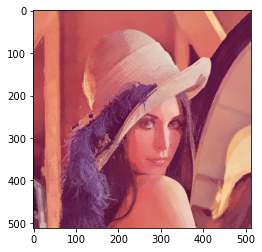

In [8]:
test = SLIC_supp(600,10,rgb)
trgb = test.run()
plt.imshow(trgb)

In [12]:
io.imsave('/slic.jpg',np.uint8(trgb*255))